# 📉 Fase 2: Ajuste de Sensibilidad y Re-optimización del Bosque

### 🧠 Contexto: Del Estándar a la Necesidad Médica
En la fase anterior (Fase 1), demostramos que el umbral estándar de **0.5** es insuficiente para la detección de Ictus, ya que prioriza la exactitud general sobre la seguridad del paciente. En este notebook, ejecutamos una **maniobra de triaje crítico**: mantenemos el análisis de hiperparámetros pero reducimos el umbral de decisión a **0.2**.

### 🎯 Objetivos de esta Fase:
1. **Validación del Motor con Mayor Sensibilidad:** Re-evaluar el impacto de `n_estimators` (50 a 400 árboles) bajo una regla de decisión mucho más permisiva (0.2).
2. **Impacto del Balanceo de Datos:** Observar qué técnica (SMOTE, ADASYN, NearMiss) logra rescatar más casos positivos sin destruir la precisión del modelo.
3. **Identificación de la Mejor Configuración:** Determinar el número de árboles y el método de remuestreo que maximice el F1-Score en este nuevo escenario de sensibilidad.

### 🩺 Hipótesis de Trabajo
Al bajar el umbral a 0.2, el **Recall** aumentará drásticamente. El desafío aquí es identificar qué método de balanceo logra el F1-Score más alto, indicando que puede manejar el aumento de falsos positivos de manera más eficiente.

🚀 Iniciando experimento comparativo (Umbral: 0.2)...
✅ Método 'SMOTE + Tomek' procesado con éxito.
✅ Método 'SMOTE + ENN' procesado con éxito.
✅ Método 'ADASYN' procesado con éxito.
✅ Método 'NearMiss' procesado con éxito.
✅ Método 'Class Weight Balanced' procesado con éxito.


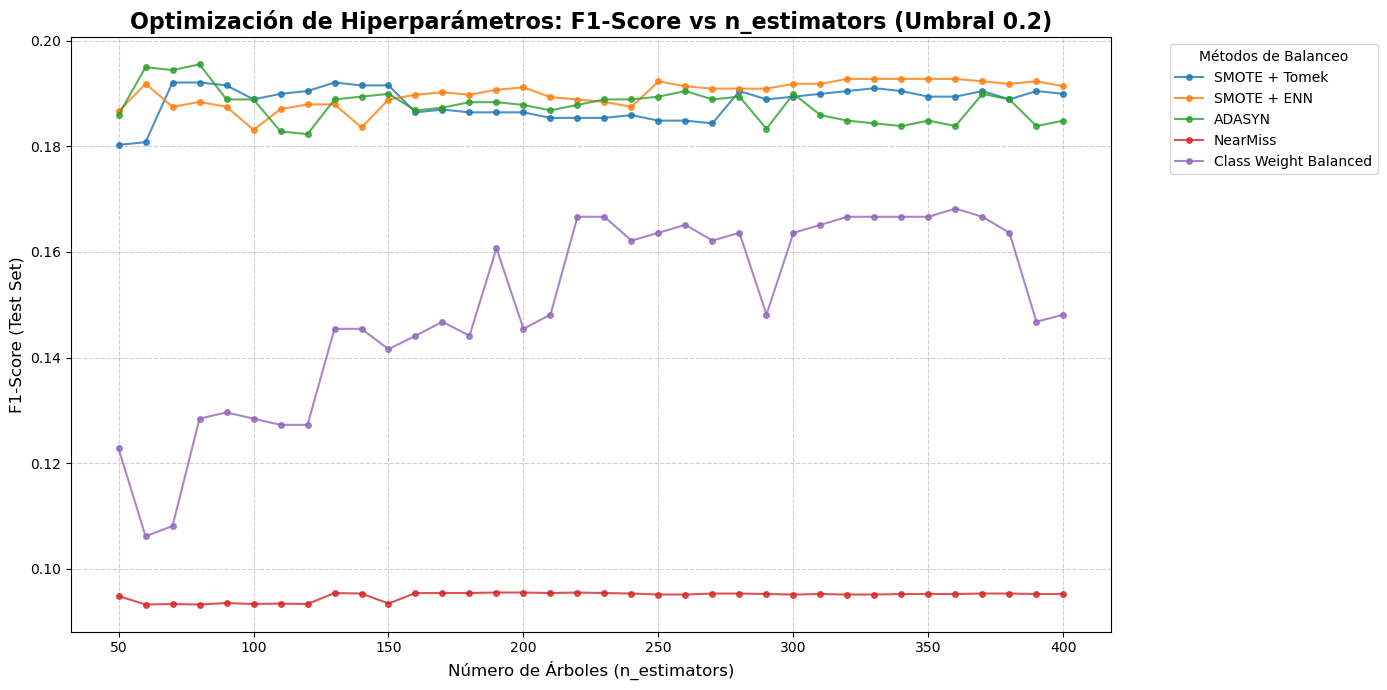


🏆 RESULTADOS DE LA COMPARATIVA:
Estrategia de Balanceo  Mejor n_estimators  F1-Score Máximo (0.2)
                ADASYN                  80                 0.1955
           SMOTE + ENN                 320                 0.1928
         SMOTE + Tomek                  70                 0.1921
 Class Weight Balanced                 360                 0.1682
              NearMiss                 190                 0.0955


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Carga y preparación (Dataset escalado para este experimento)
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Definición de métodos de balanceo
metodos = {
    "SMOTE + Tomek": (SMOTETomek(random_state=42), None),
    "SMOTE + ENN": (SMOTEENN(random_state=42), None),
    "ADASYN": (ADASYN(random_state=42), None),
    "NearMiss": (NearMiss(), None),
    "Class Weight Balanced": (None, "balanced")
}

# Rango de estimadores (de 50 a 300)
n_range = range(50, 401, 10) 
resultados = {m: [] for m in metodos}

print("🚀 Iniciando experimento comparativo (Umbral: 0.2)...")

for nombre, (resampler, weight) in metodos.items():
    # Paso A: Aplicar remuestreo si corresponde
    if resampler:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
    
    # Paso B: Entrenar variando n_estimators
    for n in n_range:
        rf = RandomForestClassifier(n_estimators=n, class_weight=weight, random_state=42, n_jobs=-1)
        rf.fit(X_res, y_res)
        
        # OBTENCIÓN DE PROBABILIDADES Y AJUSTE DE UMBRAL A 0.2
        y_probs = rf.predict_proba(X_test)[:, 1]
        y_pred_adj = (y_probs >= 0.2).astype(int)
        
        # Guardar F1-Score resultante
        resultados[nombre].append(f1_score(y_test, y_pred_adj))
        
    print(f"✅ Método '{nombre}' procesado con éxito.")

# 3. Gráfica de Evolución

plt.figure(figsize=(14, 7))
for nombre in resultados:
    plt.plot(n_range, resultados[nombre], label=nombre, marker='o', markersize=4, alpha=0.8)

plt.title("Optimización de Hiperparámetros: F1-Score vs n_estimators (Umbral 0.2)", fontsize=16, fontweight='bold')
plt.xlabel("Número de Árboles (n_estimators)", fontsize=12)
plt.ylabel("F1-Score (Test Set)", fontsize=12)
plt.legend(title="Métodos de Balanceo", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Tabla de Resumen Ejecutivo
resumen_data = []
for nombre, scores in resultados.items():
    max_f1 = max(scores)
    best_n = n_range[scores.index(max_f1)]
    resumen_data.append({
        "Estrategia de Balanceo": nombre,
        "Mejor n_estimators": best_n,
        "F1-Score Máximo (0.2)": round(max_f1, 4)
    })

df_resumen = pd.DataFrame(resumen_data).sort_values(by="F1-Score Máximo (0.2)", ascending=False)
print("\n🏆 RESULTADOS DE LA COMPARATIVA:")
print(df_resumen.to_string(index=False))

# 🏁 Conclusiones de la Fase 2: Análisis de Resultados al 0.2

### 📊 Interpretación de la Comparativa
Tras probar el rango de 50 a 400 estimadores con un umbral de 0.2, los resultados arrojan conclusiones determinantes para la evolución del proyecto:

1. **Dominio de ADASYN:** Este método ha resultado ser el más eficaz con un **F1-Score de 0.1955** utilizando apenas **80 estimadores**. Esto sugiere que la generación de muestras sintéticas en zonas "difíciles" del espacio de características ayuda al Random Forest a identificar mejor los casos de Ictus.
2. **Rendimiento de SMOTE:** Tanto SMOTE+ENN (F1: 0.1928) como SMOTE+Tomek (F1: 0.1921) muestran resultados competitivos, aunque SMOTE+ENN requiere un bosque mucho más pesado (**320 árboles**) para alcanzar su máximo potencial.
3. **El Fracaso de NearMiss:** Con un **F1-Score de 0.0955**, queda claro que el submuestreo agresivo de la clase mayoritaria elimina demasiada información valiosa, haciendo que el modelo pierda su capacidad predictiva.


